In [30]:
import numpy as np
import matplotlib.pyplot as plt
from plotter import *
from utils import *
from cluster import *
from christofide import *
from tspdp import *
from datapoint import DataPoint as dp
import time

In [31]:
name = "9RKSBbZI02fyJd2YaRe7otyFcO0Zkd.dat"

# Hybrid

Clustering done!
Intra-cluster processing done!
Inter-cluster processing done!
Breaking intra-cycles...
Heuristics done!, TSP Path found!
Total distance: 1459.8936927787609


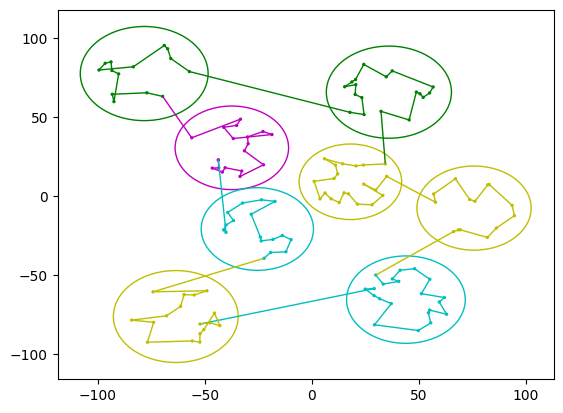

Time taken: 3024 millis


In [32]:
starttime = curtime()
X = load(name)
cpts = kmeans(X)
print("Clustering done!")
tot = len(cpts)
clusters = []
idx = 0
while idx < tot:
    start = idx
    while(idx < tot and cpts[idx].cluster == cpts[start].cluster): idx+=1
    n = idx-start
    edges = []
    for j in range(n):
        temp = []
        for k in range(n):
            temp.append(dist(cpts[j+start].x, cpts[j+start].y, cpts[k+start].x, cpts[k+start].y))
        edges.append(temp)

    ckt = christo(edges)
    for i in range(len(ckt)): ckt[i] += start
    cluster = Cluster(-1, [])
    for i in range(len(ckt)-1): 
        cluster.pts.append(cpts[ckt[i]])
    cluster.num = cluster.pts[0].cluster
    cluster.make()
    clusters.append(cluster)

print("Intra-cluster processing done!")

m = len(clusters)
inter_edges = []
for i in range(m):
    temp = []
    for j in range(m): temp.append(dist(clusters[i].x, clusters[i].y, clusters[j].x, clusters[j].y))
    inter_edges.append(temp)

if m <= 20: ckt = tspdp(inter_edges)
else: ckt = christo(inter_edges)

print("Inter-cluster processing done!")

clusters = [clusters[ckt[i]] for i in range(len(ckt)-1)]
print(f"Breaking intra-cycles...")
for i in range(m):
    x1 = clusters[(i+m-1)%m].x
    y1 = clusters[(i+m-1)%m].y
    x2 = clusters[(i+1)%m].x
    y2 = clusters[(i+1)%m].y
    start, rev, cost = 0, 0, 1e18
    pts = clusters[i].pts
    n = len(pts)
    for j in range(n):
        temp = dist(x1, y1, pts[j].x, pts[j].y) + dist(x2, y2, pts[(j+1)%n].x, pts[(j+1)%n].y) - dist(pts[j].x, pts[j].y, pts[(j+1)%n].x, pts[(j+1)%n].y)
        if(temp < cost):
            start = j
            rev = True
            cost = temp
        temp = dist(x2, y2, pts[j].x, pts[j].y) + dist(x1, y1, pts[(j+1)%n].x, pts[(j+1)%n].y) - dist(pts[j].x, pts[j].y, pts[(j+1)%n].x, pts[(j+1)%n].y)
        if(temp < cost):
            start = j
            rev = False
            cost = temp
    clusters[i].pts = cyclelist(pts, start, rev)

print("Heuristics done!, TSP Path found!")

tsp = []
for cluster in clusters:
    for pt in cluster.pts: tsp.append(pt)
        
tsp.append(tsp[0])
print(f"Total distance: {pathlen(tsp)}")
mplot(tsp, 1, 1)

print("Time taken:", curtime()-starttime, "millis")

# Sim Ann

Best fitness obtained:  1337.7264423216236
1337.726442321624


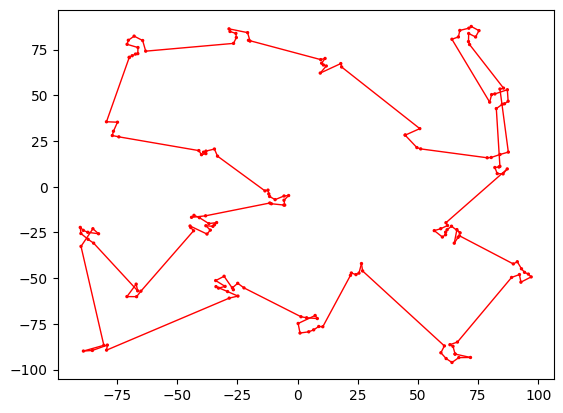

In [37]:
from tsp_opt.anneal import *
X = load(name)
cost, path = simann([(a.x, a.y) for a in X])
path.append(path[0])
print(cost)
mplot([dp(a.x, a.y) for a in path], 1, 0)

# PSO

initial cost is 1598.1323595712279
1598.1323595712279


<Figure size 640x480 with 0 Axes>

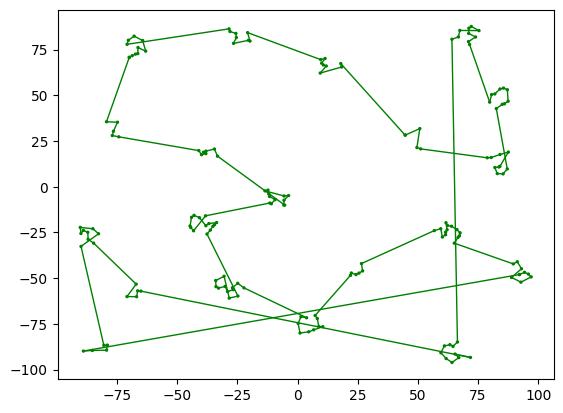

In [38]:
from tsp_opt.pso import *
X = load(name)
cost, path = tsppso([(a.x, a.y) for a in X])
path.append(path[0])
print(cost)
mplot([dp(a.x, a.y) for a in path], 1, 0)

# ACO

Shortest Path:  1409.7436970454405


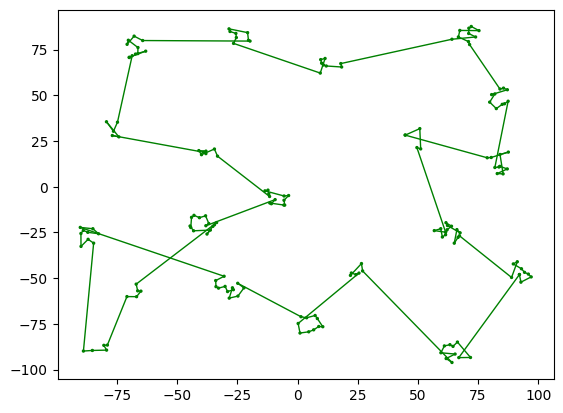

In [39]:
import numpy as np
import random
from utils import *
from datapoint import DataPoint as dp
from plotter import *

class AntColony:
    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iterations (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        
    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone * self.decay            
        return all_time_shortest_path
    
    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]
    
    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist
    
    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths
        
    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path
    
    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

# Convenience function
def np_choice(a, size, replace=True, p=None):
    """np.random.choice for a 1D array"""
    idx = np.random.choice(len(a), size=size, replace=replace, p=p)
    return np.array(a)[idx]

X = load(name)
n = len(X)
distances = np.zeros((n, n))
for i in range(n):
    for j in range(n): distances[i][j] = pdist(X[i], X[j])
np.fill_diagonal(distances, np.inf)

# Parameters
n_ants = 10
n_best = 3
n_iterations = 500
decay = 0.95

# Create colony
colony = AntColony(distances, n_ants, n_best, n_iterations, decay)

# Run the optimization
tsp = colony.run()
path = []
for s, d in tsp[0]: path.append(X[s])
path.append(X[tsp[0][0][0]])
print("Shortest Path: ", tsp[1])
for i in range(len(path)): path[i].cluster = -1
mplot(path, 1, 0)

# Solo Christofide

448.2944109517623


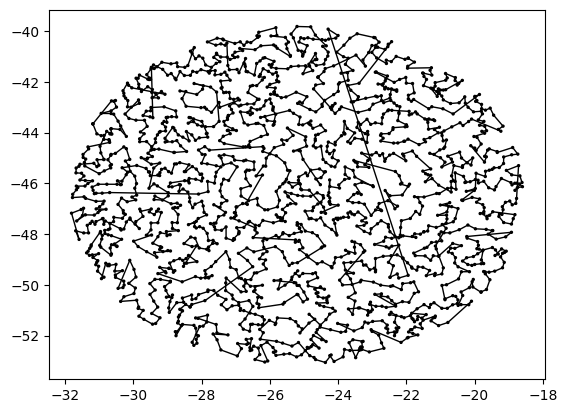

Time taken: 151695 millis


In [23]:
starttime = curtime()
def solochristo(name):
    X = load(name)
    edges = []
    n = len(X)
    for i in range(n):
        edges.append([])
        for j in range(n): edges[i].append(pdist(X[i], X[j]))
    ckt = christo(edges)
    ckt = [X[i] for i in ckt]
    print(pathlen(ckt))
    for i in range(len(ckt)): ckt[i].cluster = -1
    mplot(ckt, 1, 0)
    
solochristo(name)
print("Time taken:", curtime()-starttime, "millis")